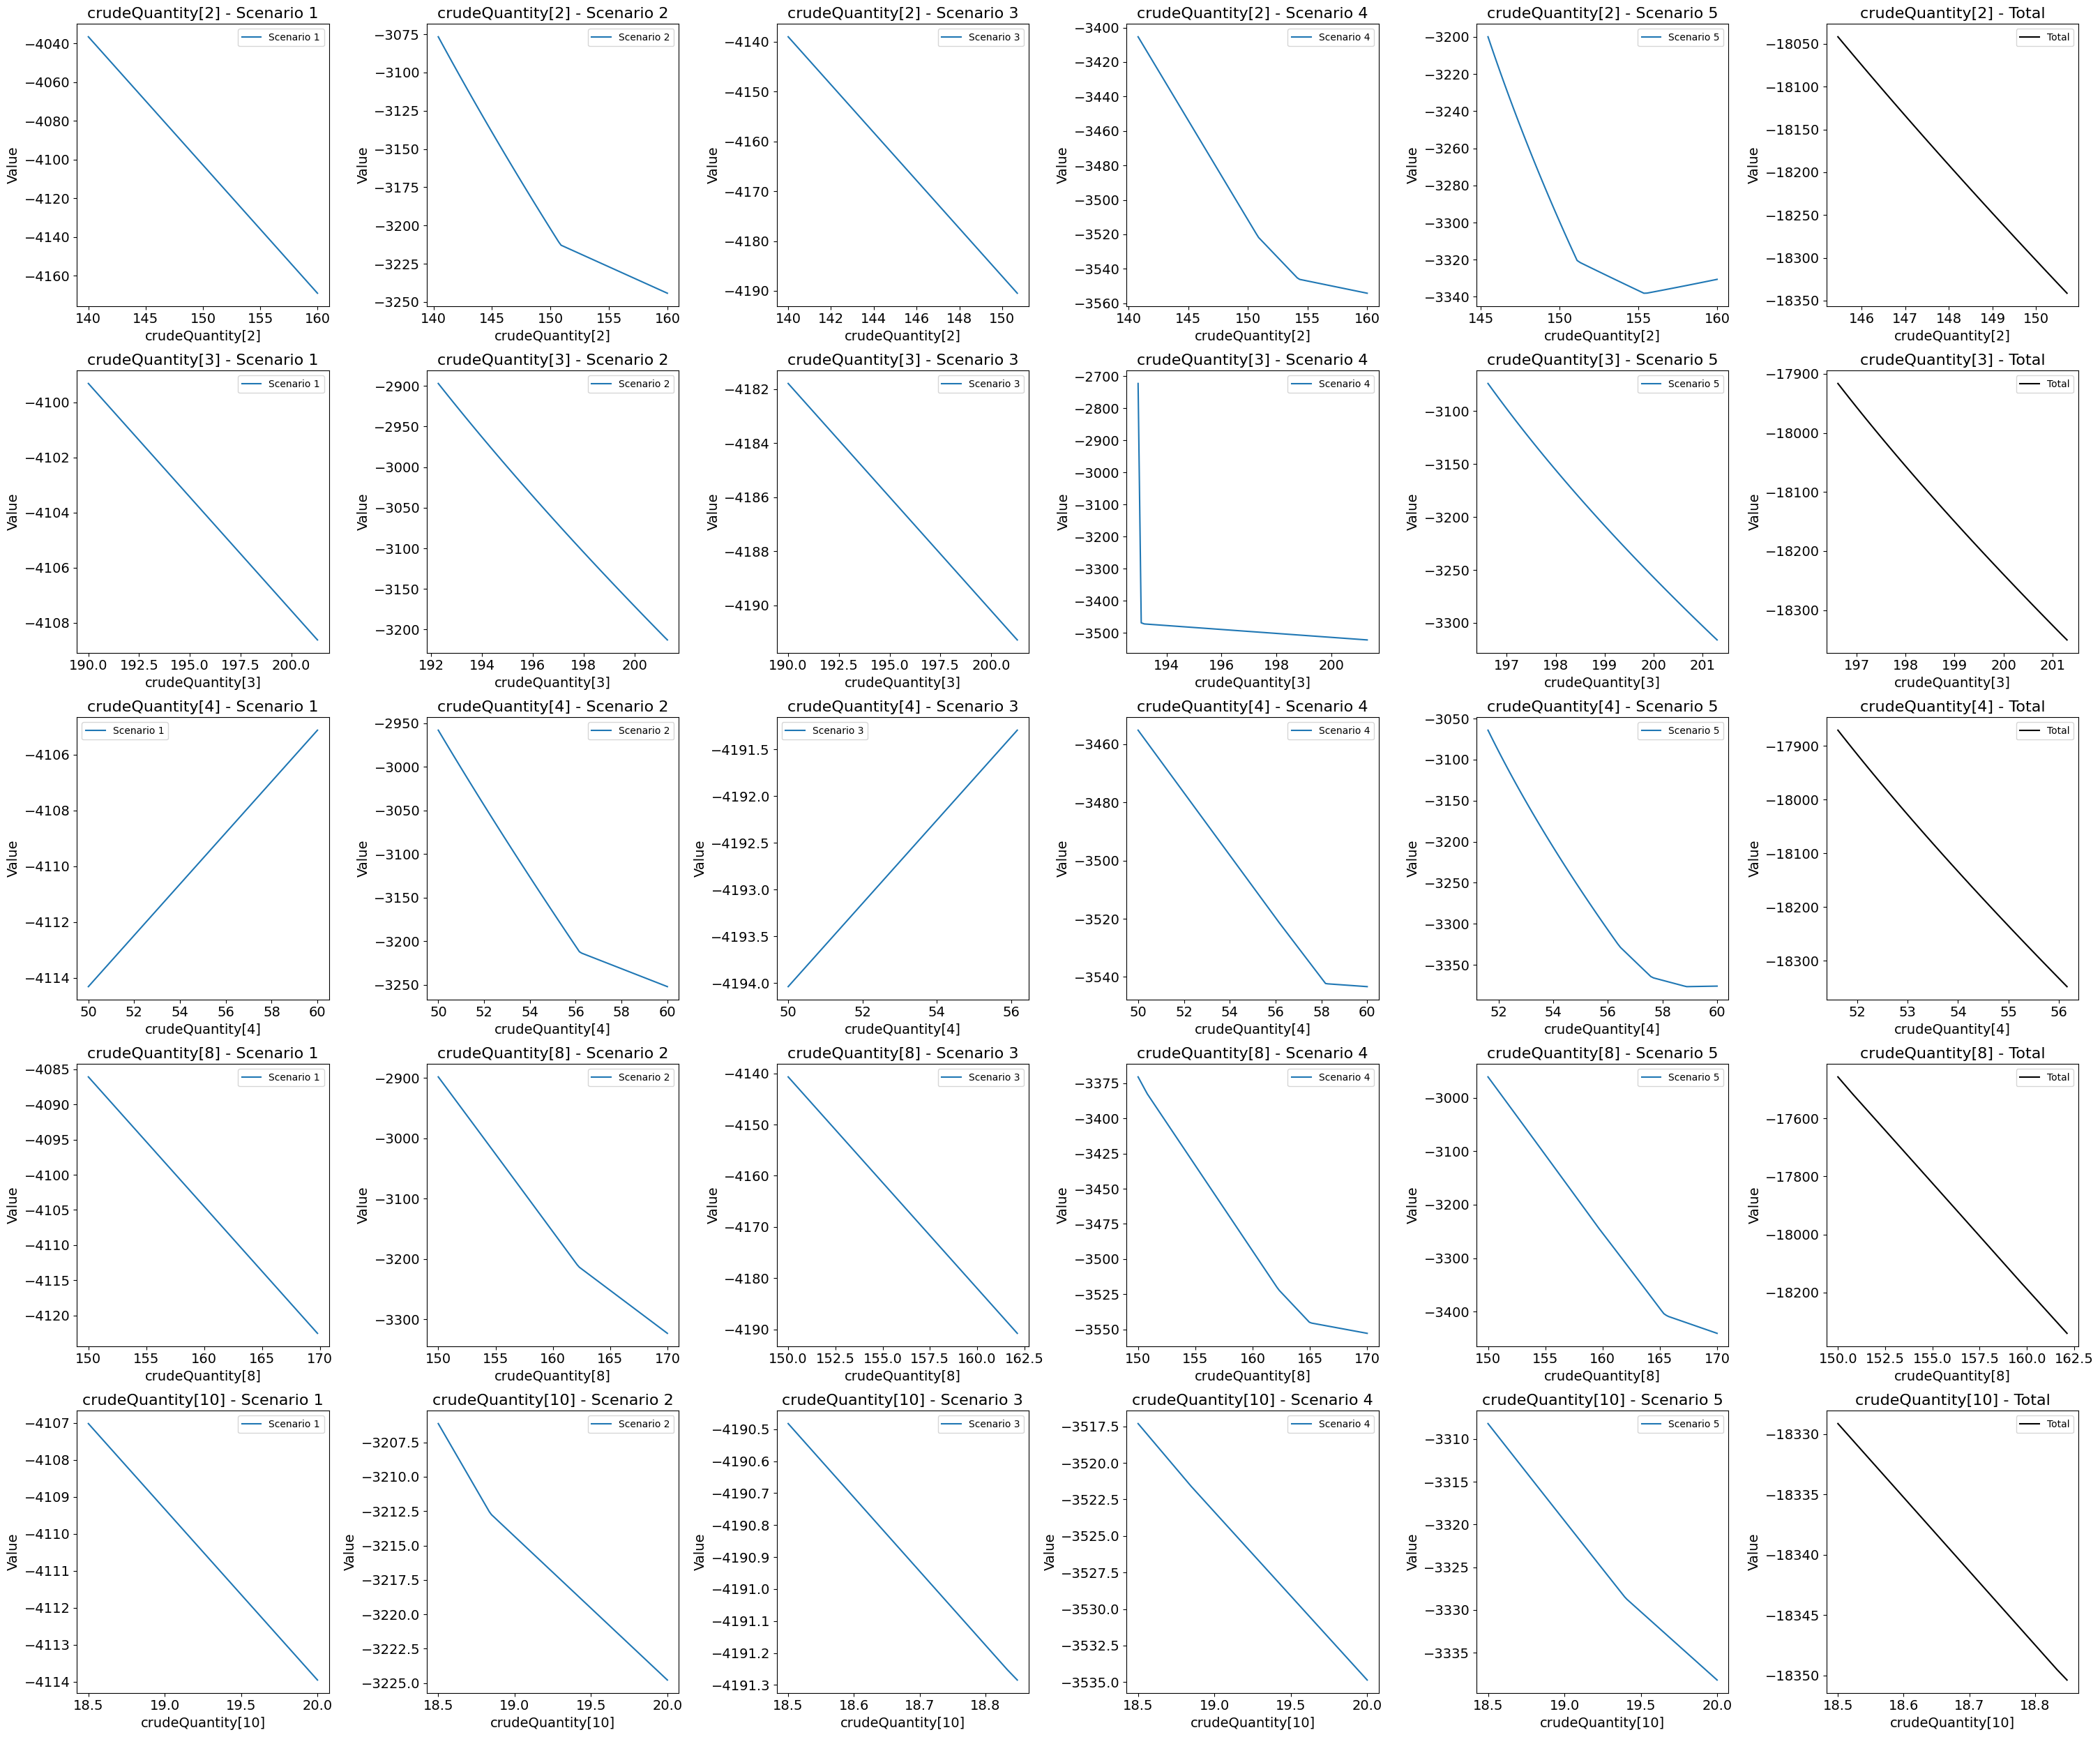

In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from pyomo.opt import SolverFactory, TerminationCondition
from src.analyses.value_function import ValueFunction
from src.analyses.convergence_analysis import HausdorffAnalyzer
import numpy as np
import matplotlib.pyplot as plt
from src.models.cz_model import CaoZavalaModel, CaoZavalaAlgo
from scipy.optimize import curve_fit
from NSPLIB.src.instances.crude_selection.crude_selection import const_model
import copy
crude_obj = -18350.146929611754
crude_sol = {f'crudeQuantity[{i}]': 0. for i in range(1, 10 + 1)}
crude_sol['crudeQuantity[2]'] = 150.87595641747944
crude_sol['crudeQuantity[3]'] = 201.29570746971186
crude_sol['crudeQuantity[4]'] = 56.18456149457359
crude_sol['crudeQuantity[8]'] = 162.2466500589715
crude_sol['crudeQuantity[10]'] = 18.848116800048512
crude_y_bound = {
    'crudeQuantity[1]': [0, 201.29570747217807],
    'crudeQuantity[2]': [0, 212.48012718600953],
    'crudeQuantity[3]': [0, 201.29570747217807],
    'crudeQuantity[4]': [0, 199.57869634340224],
    'crudeQuantity[5]': [0, 210.54848966613673],
    'crudeQuantity[6]': [0, 222.1383147853736],
    'crudeQuantity[7]': [0, 196.7885532591415],
    'crudeQuantity[8]': [0, 208.54531001589828],
    'crudeQuantity[9]': [0, 204.3720190779014],
    'crudeQuantity[10]': [0, 210.2623211446741]
}
crude_y_bound = {
    'crudeQuantity[1]': [0, 201.29570747217807],
    'crudeQuantity[2]': [140, 160],
    'crudeQuantity[3]': [190, 201.29570747217807],
    'crudeQuantity[4]': [50, 60],
    'crudeQuantity[5]': [0, 210.54848966613673],
    'crudeQuantity[6]': [0, 222.1383147853736],
    'crudeQuantity[7]': [0, 196.7885532591415],
    'crudeQuantity[8]': [150,170],
    'crudeQuantity[9]': [0, 204.3720190779014],
    'crudeQuantity[10]': [18.5, 20]
}
sto_m = const_model()
m = CaoZavalaModel.from_sto_m(sto_m)
m.build()
binary_ys = [f'pickCrude[{i}]' for i in range(1, 10 + 1)]
binary_y_val = {y: 0 for y in binary_ys}
binary_y_val['pickCrude[2]'] = 1
binary_y_val['pickCrude[3]'] = 1
binary_y_val['pickCrude[4]'] = 1
binary_y_val['pickCrude[8]'] = 1
binary_y_val['pickCrude[10]'] = 1
m.fix_binary_y(binary_y_val)
updated_y_bound=m.y_bound
updated_y_bound['crudeQuantity[1]']=(0,0)
updated_y_bound['crudeQuantity[5]']=(0,0)
updated_y_bound['crudeQuantity[6]']=(0,0)
updated_y_bound['crudeQuantity[7]']=(0,0)
updated_y_bound['crudeQuantity[9]']=(0,0)
m.update_y_bound(updated_y_bound)
y_dimension = {'crudeQuantity[2]':{}, 'crudeQuantity[3]':{}, 'crudeQuantity[4]':{},'crudeQuantity[8]':{}, 'crudeQuantity[10]':{}}

steps=100
for y in y_dimension:
    v_f= ValueFunction(m,solver="baron")
    v_f.calc_1D(idx=y, y_val_fix=copy.deepcopy(crude_sol),
                    interval= crude_y_bound[y], step = steps)
    for s in m.scenarios:
        y_dimension[y][s] = v_f.value_func[s]
    y_dimension[y]['total'] = v_f.total_value_func


fig, axs = plt.subplots(
    nrows=len(y_dimension), 
    ncols=len(m.scenarios) + 1, 
    figsize=(5 * (len(m.scenarios) + 1), 5 * len(y_dimension))
)
for row_idx, (y_key, y_data) in enumerate(y_dimension.items()):
    for col_idx, s in enumerate(m.scenarios):
        ax = axs[row_idx, col_idx] if len(y_dimension) > 1 else axs[col_idx]
        ax.plot(
            np.linspace(*crude_y_bound[y_key], steps), 
            y_data[s], 
            label=f"Scenario {s}"
        )
        ax.set_title(f"{y_key} - Scenario {s}", fontsize=16)
        ax.set_xlabel(y_key, fontsize=14)
        ax.set_ylabel("Value", fontsize=14)
        ax.tick_params(axis='both', labelsize=14)
        ax.legend()
    # Plot total in the last column
    ax = axs[row_idx, -1] if len(y_dimension) > 1 else axs[-1]
    ax.plot(
        np.linspace(*crude_y_bound[y_key], steps), 
        y_data['total'], 
        label="Total", color='black'
    )
    ax.set_title(f"{y_key} - Total", fontsize=16)
    ax.set_xlabel(y_key, fontsize=14)
    ax.set_ylabel("Value", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.legend()

plt.tight_layout()
plt.show()